In [188]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [13]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip  install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install sklearn


  Using cached sklearn-0.0.post1-py3-none-any.whl


In [15]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install seaborn


     ------------------------------------ 293.3/293.3 kB 672.3 kB/s eta 0:00:00


In [189]:
#Read the csv file
df = pd.read_csv('.csv files/nepse_NICA.csv')
print(df.head()) #7 columns, including the Date. 


  Symbol       Date   Open  Close  Volume   High    Low
0   NICA  7/14/2013  750.0  504.0      40  504.0  477.0
1   NICA  7/15/2013  504.0  554.0      40  554.0  529.0
2   NICA  7/17/2013  554.0  609.0     150  609.0  565.0
3   NICA  7/18/2013  609.0  669.0    1706  669.0  621.0
4   NICA  7/21/2013  669.0  735.0   12269  735.0  682.0


In [190]:
print(df.tail())

     Symbol       Date   Open  Close  Volume   High    Low
2183   NICA  2/20/2023  809.0  815.0   68598  819.9  798.0
2184   NICA  2/22/2023  821.0  818.0   55398  821.0  808.0
2185   NICA  2/23/2023  808.0  814.0   98136  815.0  803.4
2186   NICA  2/26/2023  810.1  810.0   98067  815.0  793.8
2187   NICA  2/27/2023  810.0  812.0   62896  820.0  801.1


In [191]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

2173   2023-02-02
2174   2023-02-05
2175   2023-02-06
2176   2023-02-07
2177   2023-02-08
2178   2023-02-09
2179   2023-02-12
2180   2023-02-14
2181   2023-02-15
2182   2023-02-16
2183   2023-02-20
2184   2023-02-22
2185   2023-02-23
2186   2023-02-26
2187   2023-02-27
Name: Date, dtype: datetime64[ns]


In [192]:
#Variables for training
cols = list(df)[2:5]


In [193]:
#Date and change columns are not used in training. 
print(cols) #['Open', 'Close', 'Volume']

['Open', 'Close', 'Volume']


In [194]:
#New dataframe with only training data - 3 columns
df_for_training = df[cols].astype(float)

<Axes: >

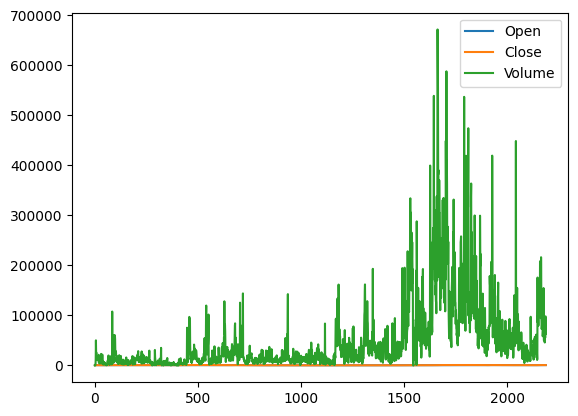

In [195]:
 df_for_plot=df_for_training.tail(5000)
 df_for_plot.plot.line()

In [196]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [197]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 3. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.


In [198]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (2266, 3)
#12823 refers to the number of data points and 3 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (2174, 14, 3).
trainY shape == (2174, 1).


In [199]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 14, 64)            17408     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [200]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_split=0.1, verbose=1)


Epoch 1/100
31/31 [==============================] - 5s 40ms/step - loss: 0.4065 - val_loss: 0.0431
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0866 - val_loss: 0.0214
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0690 - val_loss: 0.0180
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0554 - val_loss: 0.0160
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0457 - val_loss: 0.0132
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0455 - val_loss: 0.0119
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0427 - val_loss: 0.0111
Epoch 8/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0400 - val_loss: 0.0100
Epoch 9/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0394 - val_loss: 0.0109
Epoch 10/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0428 - val_loss: 0.0101

31/31 [==============================] - 1s 19ms/step - loss: 0.0267 - val_loss: 0.0024
Epoch 83/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0266 - val_loss: 0.0029
Epoch 84/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0270 - val_loss: 0.0027
Epoch 85/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0291 - val_loss: 0.0033
Epoch 86/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0287 - val_loss: 0.0028
Epoch 87/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0262 - val_loss: 0.0022
Epoch 88/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0268 - val_loss: 0.0031
Epoch 89/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0268 - val_loss: 0.0022
Epoch 90/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0253 - val_loss: 0.0033
Epoch 91/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0268 - val_loss: 0.0030
Epo

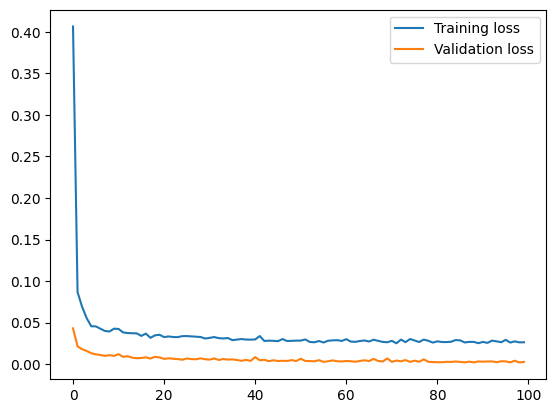

In [202]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [203]:
#forecasting
n_future = 90
forecast_period_dates=pd.date_range(list(train_dates)[-1],periods=n_future,freq='1d').tolist()
forecast = model.predict(trainX[-n_future:])#forecast


3/3 [==============================] - 0s 8ms/step


In [205]:
#Perform inverse transformation to rescale back to original range
#Since we used 3 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 3 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
print(y_pred_future)


[609.36816 613.893   607.79034 608.0989  610.04095 615.1396  628.09467
 624.13654 612.0453  610.28766 610.10046 610.57    609.14764 612.83167
 614.26666 615.985   647.89777 679.8826  690.6409  686.8357  688.62537
 684.5719  678.2996  674.75006 665.3915  660.8495  665.20435 666.96466
 672.7041  681.78906 684.853   682.03357 684.9205  691.59045 689.8572
 685.282   689.3869  700.74603 706.61487 700.12006 694.45483 688.3709
 673.84515 676.22076 677.05585 675.2263  672.51526 665.8932  664.013
 668.06226 668.42633 665.6814  684.56384 698.9109  695.65674 712.86017
 730.4551  752.8597  765.02905 774.04285 788.3179  787.29443 799.94305
 804.6521  804.6984  811.1183  810.1187  831.811   835.7301  831.6476
 825.1016  820.1104  818.0202  807.33307 802.01544 803.8952  802.8971
 805.9688  812.63495 820.3244  826.6323  830.2259  813.07367 805.1194
 805.11316 801.9964  802.94403 807.3769  802.1671  798.7834 ]


In [206]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


In [207]:
print(df_forecast['Date'])

0    2023-02-27
1    2023-02-28
2    2023-03-01
3    2023-03-02
4    2023-03-03
        ...    
85   2023-05-23
86   2023-05-24
87   2023-05-25
88   2023-05-26
89   2023-05-27
Name: Date, Length: 90, dtype: datetime64[ns]


In [208]:
original = df[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-05-1']


C:\Users\shubu\AppData\Local\Temp\ipykernel_8672\2894329927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


C:\Users\shubu\AppData\Local\Temp\ipykernel_8672\1563425839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


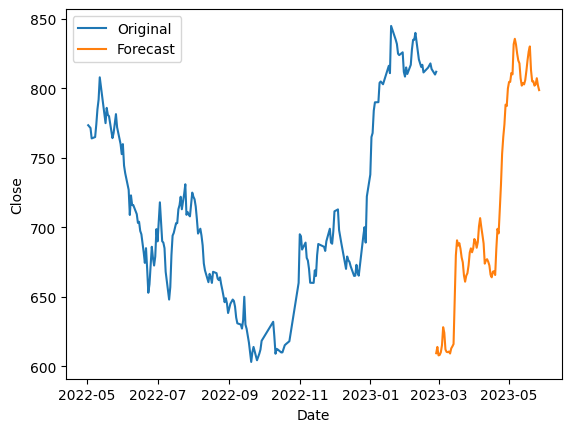

In [209]:
import matplotlib.pyplot as plt

# Plot the original data
plt.plot(original['Date'], original['Close'], label='Original')

# Plot the forecast data
plt.plot(df_forecast['Date'], df_forecast['Close'], label='Forecast')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Close')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [210]:
original = df[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-05-1']


C:\Users\shubu\AppData\Local\Temp\ipykernel_8672\2894329927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


In [211]:
model.save("NEPSE_NICA.h5")

ValueError: non-broadcastable output operand with shape (2266,1) doesn't match the broadcast shape (2266,3)